#### Importamos librerías con las que trabajaremos

In [144]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import contextily as cx
from shapely.ops import cascaded_union
from shapely import wkt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

In [72]:
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
from rasterio import mask

#### Descargamos fichero shp Comunas de Chile y seleccionamos las Provincias de Santiago, Concepcion y Valparaíso

In [3]:
comunas = gpd.read_file('C:/Users/Pablo/pyproj/Urban/Comunas/comunas.shp')

In [ ]:
# data de WorldPop
chile_pop = rasterio.open('../RM_Metro_accesibilidad/chl_ppp_2020_constrained.tif')

In [379]:
# proyectamos coordenadas
comunas.to_crs(4326, inplace=True)

In [ ]:
rm_comunas = comunas[comunas['Region']=='Región Metropolitana de Santiago']
valpo_comunas = comunas[comunas['Region']=='Región de Valparaíso']
biobio_comunas = comunas.loc[comunas['Region']=='Región del Bío-Bío']

In [ ]:
exploded = biobio_comunas.explode()
exploded.reset_index(inplace=True)
biobio_comunas = exploded.drop([17, 3, 31, 33])

In [ ]:
rm_comunas = rm_comunas.reset_index(drop=True)

In [373]:
santiago = rm_comunas[rm_comunas['Provincia']=='Santiago']

In [381]:
santiago_aoi = santiago.dissolve()

In [374]:
concepcion = biobio_comunas[biobio_comunas['Provincia']=='Concepción']

In [388]:
concepcion_aoi = concepcion.dissolve()

In [377]:
valparaiso = valpo_comunas[valpo_comunas['Provincia']=='Valparaíso']
valparaiso = valparaiso.loc[~valparaiso["Comuna"].isin(['Juan Fernández'])]

In [390]:
valparaiso_aoi = valparaiso.dissolve()

#### Filtramos ciclovías de archivo extraido de https://ciclovias.visorterritorial.cl/

In [317]:
ciclovias_chile = gpd.read_file('../bike/Ciclovias/Ciclovias1semestre_2022_VF.shp')

In [319]:
ciclovias_rm = ciclovias_chile[(ciclovias_chile['Estado_Rec']=='Existente') & (ciclovias_chile['Region']=='Metropolitana')]
ciclovias_valpo = ciclovias_chile[(ciclovias_chile['Estado_Rec']=='Existente') & (ciclovias_chile['Region']=='Valparaíso')]
ciclovias_bio = ciclovias_chile[(ciclovias_chile['Estado_Rec']=='Existente') & (ciclovias_chile['Region']=='Biobío')]

In [386]:
ciclovias_rm = gpd.clip(ciclovias_rm, santiago_aoi)

In [389]:
ciclovias_bio = gpd.clip(ciclovias_bio, concepcion_aoi)

In [391]:
ciclovias_valpo = gpd.clip(ciclovias_valpo, valparaiso_aoi)

#### Longitud Ciclovías

In [502]:
warnings.filterwarnings('ignore')
ciclovias_rm['length_km'] = ciclovias_rm.to_crs({'init': 'epsg:9155'}).length / 1000
ciclovias_rm_length = ciclovias_rm['length_km'].sum().round(1)
ciclovias_rm_length

440.2

In [503]:
warnings.filterwarnings('ignore')
ciclovias_valpo['length_km'] = ciclovias_valpo.to_crs({'init': 'epsg:9155'}).length / 1000
ciclovias_valpo_length = ciclovias_valpo['length_km'].sum().round(1)
ciclovias_valpo_length

30.3

In [504]:
warnings.filterwarnings('ignore')
ciclovias_bio['length_km'] = ciclovias_bio.to_crs({'init': 'epsg:9155'}).length / 1000
ciclovias_bio_length = ciclovias_bio['length_km'].sum().round(1)
ciclovias_bio_length

120.2

#### Cartografía Ciclovías

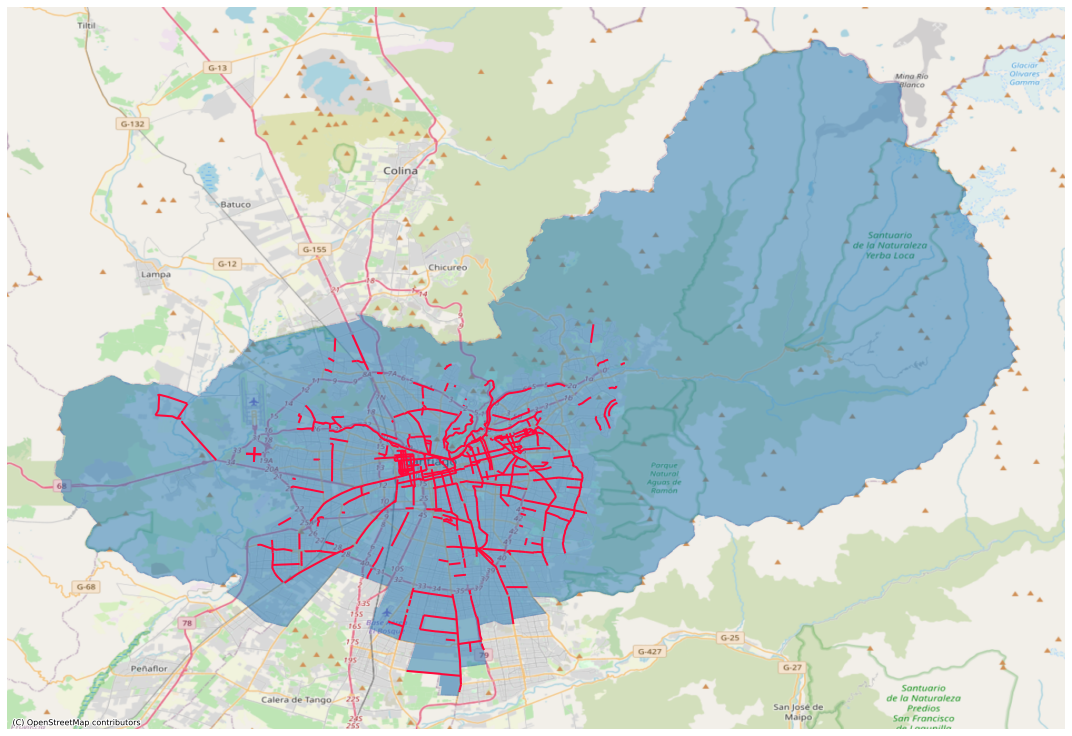

In [541]:
fig, ax = plt.subplots(figsize=(15,15))

ciclovias_rm.plot(
    ax=ax,
    color='#ff073a',
    linewidth=2
)
santiago_aoi.plot(ax=ax, alpha=.5)

cx.add_basemap(ax, crs=ciclovias_rm.crs, source=cx.providers.OpenStreetMap.Mapnik)

# buffer_cycleway.dissolve().to_crs(4326).plot(ax=ax, color='red', alpha=0.8)
# rm_comunas.plot(ax=ax, linewidth=3, facecolor='xkcd:grey blue', edgecolor='k', alpha=0.2)
ax.set_axis_off()
ax.set_aspect('equal')
plt.tight_layout();
fig.savefig('mapas/ciclovias_stgo.png', dpi=400, bbox_inches='tight')

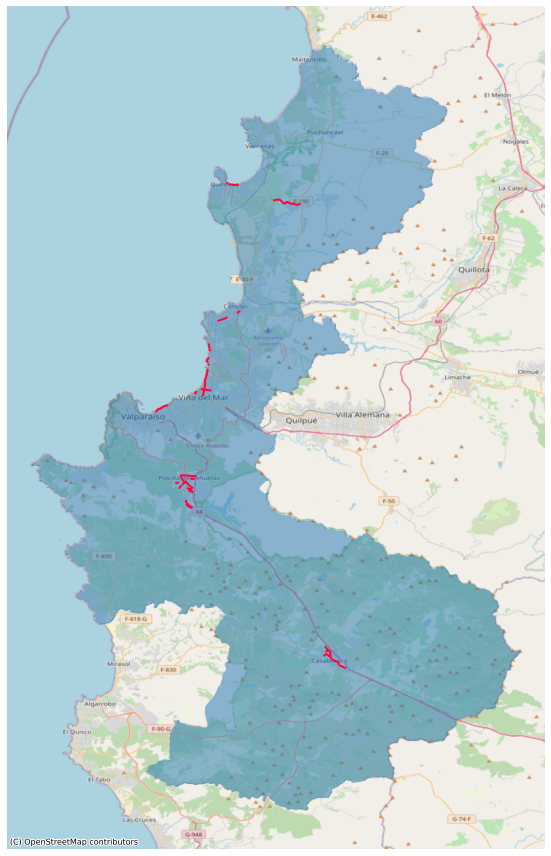

In [542]:
fig, ax = plt.subplots(figsize=(15,12))

ciclovias_valpo.plot(
    ax=ax,
    color='#ff073a',
    linewidth=2
)
valparaiso_aoi.plot(ax=ax, alpha=.5)

cx.add_basemap(ax, crs=ciclovias_valpo.crs, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
ax.set_aspect('equal')
plt.tight_layout();
# fig.savefig('mapas/ciclovias_valpo.png', dpi=400, bbox_inches='tight')

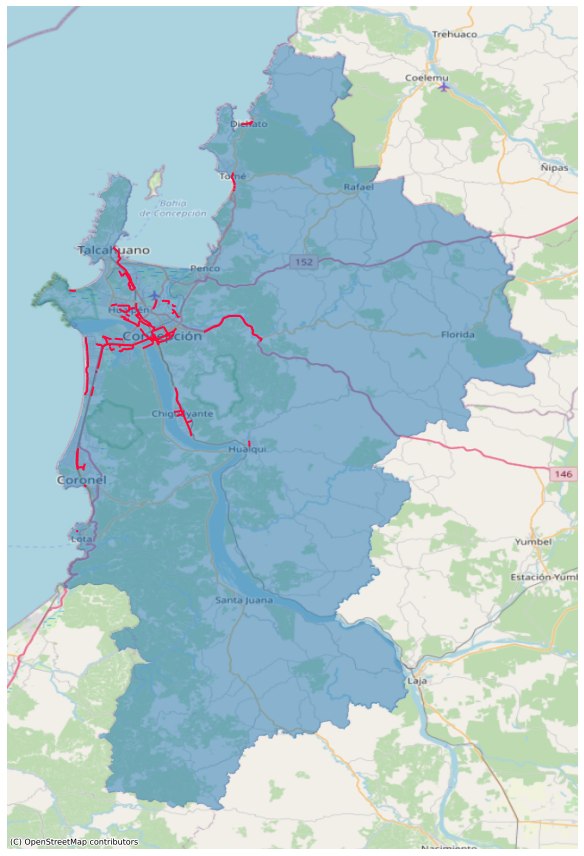

In [543]:
fig, ax = plt.subplots(figsize=(15,12))

ciclovias_bio.plot(
    ax=ax,
    color='#ff073a',
    linewidth=2
)
concepcion_aoi.plot(ax=ax, alpha=.5)

cx.add_basemap(ax, crs=ciclovias_bio.crs, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
ax.set_aspect('equal')

plt.tight_layout();
# fig.savefig('mapas/ciclovias_biobio.png', dpi=400, bbox_inches='tight')

#### Caracterizamos las ciclovías en las tres Provincias

In [505]:
aois = [santiago_aoi, valparaiso_aoi, concepcion_aoi]

In [506]:
ciclovias_aoi = [ciclovias_rm, ciclovias_valpo, ciclovias_bio]

In [507]:
ciclovias_length = [ciclovias_rm_length, ciclovias_valpo_length, ciclovias_bio_length]

In [508]:
df_regiones = []
for aoi, lanes in zip(aois, ciclovias_aoi):
    warnings.filterwarnings('ignore')
    buffer = lanes.to_crs({'init': 'epsg:9155'})  
    buffer['geometry'] = buffer.geometry.buffer(500)
    buffer = buffer.dissolve()
    gtraster, bound = mask.mask(chile_pop, aoi.loc[0,['geometry']], crop=True)
    region_pop = gtraster[0][gtraster[0]>0].sum()
    area_region = aoi.to_crs(9155).iloc[0]['geometry'].area/1000000
    try:
        gtraster2, bound2 = mask.mask(chile_pop, buffer.to_crs(4326).geometry, crop=True)
    except:
        gtraster2 = 0
    try:
        buffer_pop = gtraster2[0][gtraster2[0]>0].sum()
    except:
        buffer_pop = 0
    percentage_pop = (buffer_pop/region_pop*100).round(1)
    pop_region = {
        'region': aoi.iloc[0]['Region'],
        'porcentaje': percentage_pop,
        'pop': region_pop,
        'area': area_region,
        'densidad': region_pop/area_region,
    }
    df_regiones.append(pop_region)  

In [509]:
df_reg = pd.DataFrame (df_regiones, columns = ['region', 'porcentaje', 'pop', 'area', 'densidad'])

In [510]:
df_reg['km_ciclovias'] = ciclovias_length

In [511]:
df_reg['km_ciclovias/densidad'] = df_reg['km_ciclovias']/df_reg['densidad']

In [512]:
df_reg['km_ciclovias/area'] = df_reg['km_ciclovias']/df_reg['area']

In [513]:
df_reg

,region,porcentaje,pop,area,densidad,km_ciclovias,km_ciclovias/densidad,km_ciclovias/area
0,Región Metropolitana de Santiago,52.1,6.062256e+06,2029.369692,2987.260785,440.2,0.147359,0.216915
1,Región de Valparaíso,21.4,7.529029e+05,1905.824125,395.053734,30.3,0.076698,0.015899
2,Región del Bío-Bío,47.2,1.154629e+06,3439.009810,335.744717,120.2,0.358010,0.034952


#### Analizamos algunas métricas para las comunas de la Provincia de Santiago

In [466]:
comunas_stgo = ['La Florida', 'Peñalolén', 'Ñuñoa', 'La Reina', 'Las Condes',
       'Vitacura', 'Lo Barnechea', 'Providencia', 'Santiago',
       'Independencia', 'Recoleta', 'Conchalí', 'Huechuraba',
       'La Pintana', 'La Granja', 'San Ramón',
       'La Cisterna', 'San Joaquín', 'Macul', 'San Miguel', 'Pudahuel',
       'Quinta Normal', 'Cerro Navia', 'Renca', 'Quilicura', 'El Bosque',
       'Lo Espejo', 'Maipú', 'Cerrillos', 'Pedro Aguirre Cerda',
       'Estación Central', 'Lo Prado']

In [484]:
df_pop_comunas = []
for comuna in comunas_stgo:
    ciclovia = ciclovias_rm[ciclovias_rm['Comuna']==comuna]
    warnings.filterwarnings('ignore')
    length_km = ciclovias_rm[ciclovias_rm['Comuna']==comuna]['length_km'].sum()
    warnings.filterwarnings('ignore')
    # buffer = ciclovia.to_crs({'init': 'epsg:9155'})  
    # buffer['geometry'] = buffer.geometry.buffer(500)
    # buffer_clip = gpd.clip(buffer.to_crs(4326), rm_comunas.iloc[i]['geometry'])
    gtraster, bound = mask.mask(chile_pop, santiago.set_index('Comuna').loc[comuna,['geometry']], crop=True)
    comuna_pop = gtraster[0][gtraster[0]>0].sum()
    area_comuna = (santiago[santiago['Comuna']==comuna].to_crs(9155).area/1000000).iloc[0]
    # try:
    #     gtraster2, bound2 = mask.mask(chile_pop, buffer_clip.to_crs(4326).geometry, crop=True)
    # except:
    #     gtraster2 = 0
    # try:
    #     buffer_pop = gtraster2[0][gtraster2[0]>0].sum()
    # except:
    #     buffer_pop = 0
    # percentage_pop = (buffer_pop/comuna_pop*100).round(1)
    pop_comuna = {
        'comuna': santiago[santiago['Comuna']==comuna]['Comuna'].iloc[0],
        # 'porcentaje': percentage_pop,
        'length_km': length_km,
        'pop': comuna_pop,
        'area': area_comuna,
        'densidad': comuna_pop/area_comuna,
    }
    df_pop_comunas.append(pop_comuna)    

In [489]:
df_comunas = pd.DataFrame (df_pop_comunas, columns = ['comuna', 'length_km', 'pop', 'area', 'densidad'])

In [490]:
df_comunas['km_ciclovias/area'] = df_comunas['length_km']/df_comunas['area']

In [492]:
df_comunas.sort_values(by='length_km', ascending = False).head(10)

,comuna,length_km,pop,area,densidad,km_ciclovias/area
8,Santiago,64.625142,1.351865e+05,23.167629,5835.144643,2.789459
4,Las Condes,42.851109,3.367222e+05,98.396074,3422.110621,0.435496
7,Providencia,35.098538,1.351263e+05,14.396523,9386.038190,2.437987
2,Ñuñoa,24.900475,1.301523e+05,16.911880,7695.908287,1.472366
27,Maipú,24.197122,1.589293e+06,138.038031,11513.442073,0.175293
13,La Pintana,23.575777,2.224293e+05,30.491222,7294.863403,0.773199
1,Peñalolén,22.345541,2.898911e+05,53.468188,5421.749518,0.417922
20,Pudahuel,20.456719,3.831518e+05,198.117242,1933.964842,0.103256
3,La Reina,18.472728,9.483684e+04,23.334550,4064.224181,0.791647
0,La Florida,16.573435,4.449568e+05,71.037327,6263.704324,0.233306


In [487]:
df.length_km.sum().round(0), df.area.sum().round(0), df['pop'].sum().round(0), len(df)

(439.0, 2029.0, 6062256.0, 32)